## Stereo vision calibration
Dataset: https://www.kaggle.com/datasets/danielwe14/stereocamera-chessboard-pictures

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import glob
import sys

if '/Users/damianstone/Documents/Code/tennis-project/post-triangulation/' not in sys.path:
  sys.path.append('/Users/damianstone/Documents/Code/tennis-project/post-triangulation/')


In [2]:
def print_image(imread_img):
  img = cv.cvtColor(imread_img, cv.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

### Find chessboard corners - object points and image points
This step helps the computer learn how a flat chessboard looks in pictures. It finds corner points, compares them to real-world positions, and fixes camera distortions to make images more accurate

LEFT


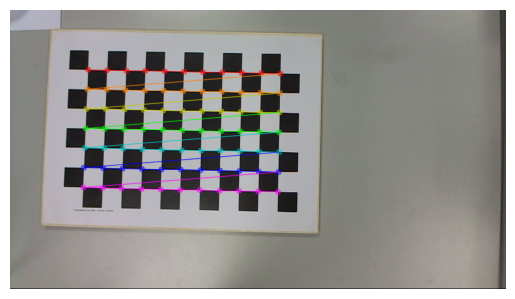

RIGHT


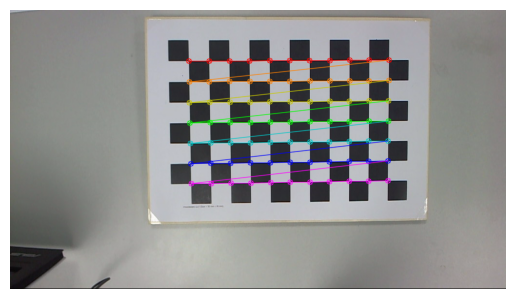

LEFT


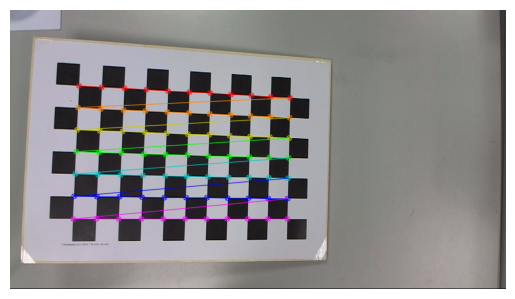

RIGHT


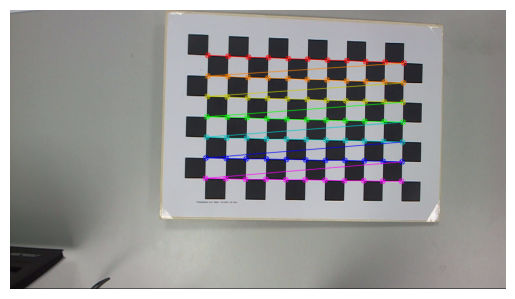

LEFT


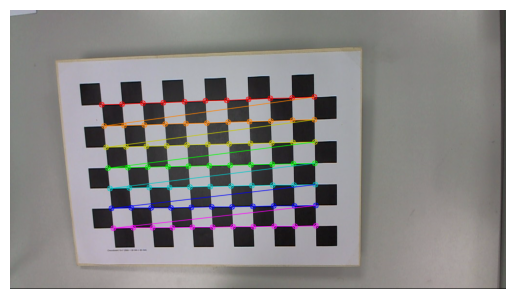

RIGHT


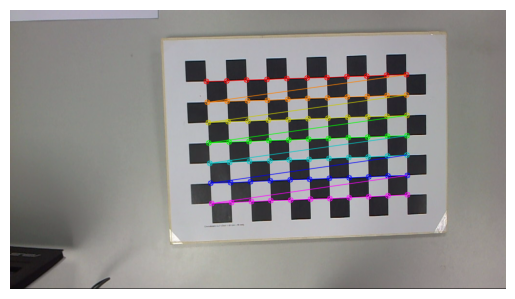

In [3]:
# number of inner coners - rows and columns
chessboard_size = (11, 7)

img = cv.imread('/Users/damianstone/Documents/Code/tennis-project/post-triangulation/images/stereoRight/Im_R_1.png')
height, width = img.shape[:2]

# size of the image
frame_size = (width, height)

# how exact we want to be find the corners of each square in the chessboard 
# 30 = max number of iterations
# 0.001 = stop if the change in the corner position is less than 0.001 - convergence threshold 
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# create 3D points of the chessboard corners
# each row represents a coordinate of a corner of the chessboard
# corner = interesection between two squares
objp = np.zeros(
  (chessboard_size[0] * chessboard_size[1], 3), 
  np.float32
)

# it generates a grid of (x, y) coordinates for chessboard corners and stores them as 3D points with z = 0 for calibration
# z = 0 because the chessboard is flat
objp[:,:2] = np.mgrid[
  0:chessboard_size[0],
  0:chessboard_size[1]
  ].T.reshape(-1,2)

# scale the 3D points to real world size
size_of_chessboard_squares_mm = 30
objp = objp * size_of_chessboard_squares_mm

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints_l = [] # 2d points in image plane
imgpoints_r = [] # 2d points in image plane


images_left = glob.glob('/Users/damianstone/Documents/Code/tennis-project/post-triangulation/images/stereoLeft/*.png')
images_right = glob.glob('/Users/damianstone/Documents/Code/tennis-project/post-triangulation/images/stereoRight/*.png')

i = 0
for img_left, img_right in zip(images_left, images_right):
  img_l = cv.imread(img_left)
  img_r = cv.imread(img_right)

  gray_l = cv.cvtColor(img_l, cv.COLOR_BGR2GRAY)
  gray_r = cv.cvtColor(img_r, cv.COLOR_BGR2GRAY)

  # find the chessboard corners
  ret_l, corners_l = cv.findChessboardCorners(gray_l, chessboard_size, None)
  ret_r, corners_r = cv.findChessboardCorners(gray_r, chessboard_size, None)

  # if corners are found, add object points, image points (after refining them)
  if ret_l and ret_r:
    # store the same object for each image
    objpoints.append(objp)

    # get all the coordinates of the corners
    corners_l = cv.cornerSubPix(gray_l, corners_l, (11, 11), (-1, -1), criteria)
    # append the corners to the imgpoints list
    imgpoints_l.append(corners_l)

    corners_r = cv.cornerSubPix(gray_r, corners_r, (11, 11), (-1, -1), criteria)
    imgpoints_r.append(corners_r)

    if i < 3:
      #draw and display the corners
      cv.drawChessboardCorners(img_l, chessboard_size, corners_l, ret_l)
      print("LEFT")
      print_image(img_l)
      cv.drawChessboardCorners(img_r, chessboard_size, corners_r, ret_r)
      print("RIGHT")
      print_image(img_r)
      i += 1
    cv.waitKey(1000)

cv.destroyAllWindows()



### Intrinsic Calibration
This step calibrates each camera separately by estimating its intrinsic parameters and correcting distortions

1. Get intrinsic parameters = parameters that describe how a camera sees the world. focal length, optical center and distorsion coefficient
2. The original camera matrix includes distorsion, so using the intrinsic parameters we get a new matrix with corrected distorsion

What happen if we don't do intrinsic calibration? 

In [4]:
# intrinsic parameters
# ret = reprojection error
# dist = distortion coefficients -> how much the lens bends the image (q tanto curva la imagen el lente)
# rvecs = rotation vectors
# tvecs = translation vectors
ret_l, cameramatrix_l, dist_l, rvecs_l, tvecs_l = cv.calibrateCamera(objpoints, imgpoints_l, frame_size, None, None)
height_l, width_l, channels_l = img_l.shape
# adjust cameras matrix to reduce distortion
newcameramtx_l, roi_l = cv.getOptimalNewCameraMatrix(
                              cameramatrix_l, 
                              dist_l, 
                              (width_l, height_l), 
                              1, 
                              (width_l, height_l)
                          )

# get intrinsic parameters for the right camera
ret_r, cameramatrix_r, dist_r, rvecs_r, tvecs_r = cv.calibrateCamera(objpoints, imgpoints_r, frame_size, None, None)
height_r, width_r, channels_r = img_r.shape

# correct distortion from the original matrix and get the region of interest
newcameramtx_r, roi_r = cv.getOptimalNewCameraMatrix(
                              cameramatrix_r, 
                              dist_r, 
                              (width_r, height_r), 
                              1, 
                              (width_r, height_r)
                          )


### Stereo vision calibration
So far we calibrated each camera individually (intrinsic calibration), so now we have to understand how both cameras relate each other

1. Find the exact position of one camera relative to the other
2. Align images correctly for depth perception
3. Compute the Essential and Fundamental matrices -> how points move between both cameras

No stereo calibration, no depth estimation

In [5]:
# flags control how the calibration works 
flags = 0
# CALIB_FIX_INTRINSIC -> not change the intrinsic parameters we already calculated
# meaning we only want to calibrate how the cameras relate to each other not recalibrate them individually
flags |= cv.CALIB_FIX_INTRINSIC

# iteration stopping criteria
# 30 iterations or until the change in the parameters is less than 0.001
criteria_stereo = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# stereoCalibrate
# R = rotation matrix
# T = translation vector
# E = essential matrix
# F = fundamental matrix
ret_stereo, new_cameramatrix_l, dist_l, new_cameramatrix_r, dist_r, R, T, E, F = cv.stereoCalibrate(
  objpoints, 
  imgpoints_l, 
  imgpoints_r, 
  newcameramtx_l, 
  dist_l, 
  newcameramtx_r, 
  dist_r, 
  gray_l.shape[::-1], 
  criteria_stereo, 
  flags
)


### Stereo rectification
Aligns the images from both cameras so objects appear on the same row in both images. Simplifies the process of finding corresponding points



In [6]:
rectify_scale = 1

# stereoRectify -> calculates transformation matrices to correct distotion and align the images

# rect_l = rectification transform (rotation matrix)
# rect_r = rectification transform (rotation matrix)
# proj_matrix_l = projection matrix in new (rectified) coord system for the left camera
# proj_matrix_r = projection matrix in new (rectified) coord system for the right camera
# Q = disparity-to-depth mapping matrix
# roi_l = region of interest in the rectified image
# roi_r = region of interest in the rectified image
rect_l, rect_r, proj_matrix_l, proj_matrix_r, Q, roi_l, roi_r = cv.stereoRectify(
  new_cameramatrix_l, 
  dist_l, 
  new_cameramatrix_r, 
  dist_r, 
  gray_l.shape[::-1], 
  R, 
  T, 
  rectify_scale,
  (0, 0)
)

# correct distortion and apply rectification
stereo_map_l = cv.initUndistortRectifyMap( # output maps which are pre-made instructions to quickly adjust the images before depth estimation
  new_cameramatrix_l, 
  dist_l, 
  rect_l, 
  proj_matrix_l, 
  gray_l.shape[::-1],
  cv.CV_16SC2
)

stereo_map_r = cv.initUndistortRectifyMap(
  new_cameramatrix_r, 
  dist_r, 
  rect_r, 
  proj_matrix_r, 
  gray_r.shape[::-1],
  cv.CV_16SC2
)


### Save parameters
Save the stereo maps (pre-made instructions) so we can use them for new images

In [8]:
print("Saving parameters!")
path = "/Users/damianstone/Documents/Code/tennis-project/post-triangulation/data"
cv_file = cv.FileStorage(f'{path}/simple_calibration_params.xml', cv.FILE_STORAGE_WRITE)

cv_file.write('stereoMap_L_x', stereo_map_l[0])
cv_file.write('stereoMap_L_y', stereo_map_l[1])
cv_file.write('stereoMap_R_x', stereo_map_r[0])
cv_file.write('stereoMap_R_y', stereo_map_r[1])

cv_file.release()

Saving parameters!
